# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [25]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [26]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")

# Import Data

In [27]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)
df_neighborhood_locations.columns = ['neighborhood', 'lat', 'lon']

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [28]:
# Define Panel Visualization Functions
def housing_units_per_year():
    year_df = sfo_data.groupby(['year'])
    year_df_units_mean = year_df['housing_units'].mean()
    year_df_units_std = year_df_units_mean.std()
    year_df_units_min = year_df_units_mean.min() - year_df_units_std
    year_df_units_max = year_df_units_mean.max() + year_df_units_std    
    fig = year_df_units_mean.plot(kind='bar', ylim=(year_df_units_min, year_df_units_max))
    return fig

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    year_df = sfo_data.groupby(['year'])
    avg_gross_rent = year_df['gross_rent'].mean()
    return avg_gross_rent.plot.line()
    
def average_sales_price():
    """Average Sales Price Per Year."""
    year_df = sfo_data.groupby(['year'])
    avg_sale_price = year_df['sale_price_sqr_foot'].mean()
    return avg_sale_price.plot.line()


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    neighborhood = "Bayview"
    year_df = sfo_data.groupby(['year'])
    grouped_neighborhood = sfo_data.loc[sfo_data['neighborhood'] == neighborhood]['sale_price_sqr_foot']
    title = f'{neighborhood} Average Price Per Sq Ft'
    return grouped_neighborhood.hvplot.line(title=title)


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    most_expensive = sfo_data.groupby(by='neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False).head(10)
    return most_expensive['sale_price_sqr_foot'].plot.bar()
    # YOUR CODE HERE!


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    most_expensive = sfo_data.groupby(by='neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False).head(10)
    px.parallel_coordinates(most_expensive, color=most_expensive.index)
    
def parallel_categories():
    """Parallel Categories Plot."""
    most_expensive = sfo_data.groupby(by='neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False).head(10)
    px.parallel_categories(most_expensive, color='sale_price_sqr_foot', color_continuous_scale=px.colors.sequential.Inferno)


def neighborhood_map():
    """Neighborhood Map"""
    
    px.set_mapbox_access_token(mapbox_token)
    mean_neighborhood = sfo_data.groupby(by='neighborhood').mean()
    mean_neighborhood.reset_index(inplace=True)
    merged_df = pd.merge(mean_neighborhood, df_neighborhood_locations, on='neighborhood')
    
    fig = px.scatter_mapbox(merged_df,
                     lat='lat',
                     lon='lon',
                     size='sale_price_sqr_foot',
                     color='gross_rent',
                     hover_name='neighborhood',
                     zoom=10,
                     color_continuous_scale=px.colors.sequential.Jet)
    return fig


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

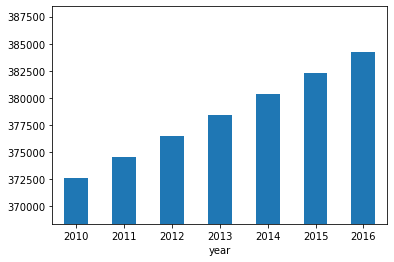

In [29]:
geo_column = pn.Column(
    "Neighborhood Map", neighborhood_map()
)
basic_column = pn.Column(
    "##Housing Units Per Year", housing_units_per_year(), "##Average Gross Rent in San Francisco Per Year", average_gross_rent(), 
    "##Average Sales Price Per Year", average_sales_price()
)
avg_price_column = pn.Column(
    "##Average Price By Neighborhood", average_price_by_neighborhood()
)
paralell_column = pn.Column(
    "##Parallel Coordinates", parallel_coordinates(), "##Parallel Categories", parallel_categories()
)

dashboard = pn.Tabs(
    ("Geo Map", geo_column), ("Units/Avg Sales Price Per Year", basic_column), ("AVG Price", avg_price_column), ("Parallel Charts", paralell_column)
)

## Serve the Panel Dashboard

In [30]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Markdown(str)
        [3] Str(AxesSubplot)
        [4] Markdown(str)
        [5] Str(AxesSubplot)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Curve)
    [3] Column
        [0] Markdown(str)
        [1] Str(None)
        [2] Markdown(str)
        [3] Str(None)